# Leitura

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) 

In [2]:
df = pd.read_csv("../data/output/apartamentos.csv")
df.head(5)

,id,origem,tipo,metragem,quartos,banheiros,vagas,preco,condominio,lat,lng,endereco,title,desc,url,imagens,url_google,preco_total,linha,estacao,distance
0,2427403915,zap,Aluguel,85,2.0,3,2.0,1600,700,-23.019958,-43.468934,Rua Joaquim da Silveira - Recreio Dos Bandeira...,"EXCELENTE APARTAMENTO DE FRENTE, 02 VARANDAS, ...","EXCELENTE APARTAMENTO DE FRENTE, 02 VARANDAS, ...",https://www.zapimoveis.com.br/imovel/aluguel-a...,['https://resizedimgs.zapimoveis.com.br/fit-in...,"https://maps.google.com/maps?ll=-23.019958,-43...",2300,Linha Santa Cruz da SuperVia,Estação João Ellis,15588.256452
1,2430193035,zap,Aluguel,65,2.0,1,1.0,3250,395,-22.952231,-43.191094,"Rua das Palmeiras, 59 - Botafogo, Rio de Janei...","Alugo excelente apartamento , Rua das Palmeira...","Alugo excelente apartamento , Rua das Palmeira...",https://www.zapimoveis.com.br/imovel/aluguel-a...,['https://resizedimgs.zapimoveis.com.br/fit-in...,"https://maps.google.com/maps?ll=-22.952231,-43...",3645,Linha 1 do Metrô do Rio de Janeiro,Estação Botafogo,742.621192
2,2432000405,zap,Aluguel,40,1.0,1,1.0,2650,674,-22.983918,-43.224269,"Rua General Urquiza - Leblon, Rio de Janeiro - RJ",Excelente apartamento em rua tranquila. Último...,Excelente apartamento em rua tranquila. Último...,https://www.zapimoveis.com.br/imovel/aluguel-a...,['https://resizedimgs.zapimoveis.com.br/fit-in...,"https://maps.google.com/maps?ll=-22.983918,-43...",3324,Linha 4 do Metrô do Rio de Janeiro,Estação Antero de Quental,153.520741
3,2439213385,zap,Aluguel,130,3.0,3,1.0,2500,1332,-22.934498,-43.187515,"Rua das Laranjeiras - Laranjeiras, Rio de Jane...","Excelente localização! Vasto comercio, totalme...","Excelente localização! Vasto comercio, totalme...",https://www.zapimoveis.com.br/imovel/aluguel-a...,['https://resizedimgs.zapimoveis.com.br/fit-in...,"https://maps.google.com/maps?ll=-22.934498,-43...",3832,Linha 1 do Metrô do Rio de Janeiro,Estação Flamengo,988.938859
4,2440890746,zap,Aluguel,60,2.0,2,1.0,1300,630,-22.890541,-43.219149,"Rua Monsenhor Manuel Gomes - São Cristóvão, Ri...",Condomínio Neo Life São Cristóvão apartamento ...,Condomínio Neo Life São Cristóvão apartamento ...,https://www.zapimoveis.com.br/imovel/aluguel-a...,['https://resizedimgs.zapimoveis.com.br/fit-in...,"https://maps.google.com/maps?ll=-22.890541,-43...",1930,Linha Japeri da SuperVia,Estação São Cristóvão (Rio de Janeiro),2150.766336


In [3]:
df.shape

(153, 21)

In [4]:
df = df.set_index("id")

# Treino e teste

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[
        "preco", "condominio", "tipo", "origem", "endereco", "title", "url", "imagens", "url_google", "preco_total"
    ]), df.preco_total
)

X_train.head(5)

,metragem,quartos,banheiros,vagas,lat,lng,desc,linha,estacao,distance
id,,,,,,,,,,
2498593303,70,3.0,1,2.0,-22.917483,-43.563210,O apartamento no bairro Campo Grande com 70 me...,Linha Santa Cruz da SuperVia,Estação Campo Grande (Rio de Janeiro),1715.367197
2488813019,64,2.0,2,1.0,-23.003721,-43.328289,"Apartamento de 2 quartos, banheiro social, lav...",Linha 4 do Metrô do Rio de Janeiro,Estação Jardim Oceânico,1841.818211
2478241691,340,4.0,5,2.0,-22.984139,-43.200713,Belo apartamento de alto padrão para locação n...,Linha 1 do Metrô do Rio de Janeiro,Estação General Osório,468.280446
2498741777,83,2.0,1,0.0,-22.936625,-43.175450,"OSala,02quartos,suíte,closet,armários,banheiro...",Linha 1 do Metrô do Rio de Janeiro,Estação Flamengo,303.010230
2499144201,80,3.0,3,1.0,-22.941100,-43.332213,Freguesia - Ótimo apartamento no melhor bairro...,Linha Deodoro da SuperVia,Estação Quintino,5930.641476


# Preprocessamento

In [7]:
X_train.isna().sum()

metragem     0
quartos      0
banheiros    0
vagas        0
lat          0
lng          0
desc         0
linha        0
estacao      0
distance     0
dtype: int64

In [8]:
X_train[X_train.desc.isna()]

,metragem,quartos,banheiros,vagas,lat,lng,desc,linha,estacao,distance
id,,,,,,,,,,


In [9]:
X_train['linha'].value_counts()

Linha 1 do Metrô do Rio de Janeiro    61
Linha 4 do Metrô do Rio de Janeiro    22
Linha Deodoro da SuperVia             13
Linha Santa Cruz da SuperVia           7
Linha 2 do Metrô do Rio de Janeiro     5
Linha Belford Roxo da SuperVia         3
Linha Japeri da SuperVia               2
Linha Saracuruna da SuperVia           1
Name: linha, dtype: int64

In [10]:
X_train['estacao'].value_counts()

Estação Botafogo                            10
Estação Uruguai                              9
Estação Siqueira Campos                      9
Estação Flamengo                             7
Estação Cardeal Arcoverde                    7
Estação Jardim Oceânico                      6
Estação Nossa Senhora da Paz                 6
Estação Gávea                                5
Estação General Osório                       4
Estação Saens Peña                           3
Estação João Ellis                           3
Estação Glória                               3
Estação Quintino                             3
Estação Antero de Quental                    3
Estação São Conrado                          2
Estação Maria da Graça (Metrô Rio)           2
Estação Praça da Bandeira                    2
Estação Engenho Novo                         2
Estação Catete                               2
Estação Silva Freire                         2
Estação Central (Metrô Rio)                  2
Estação São F

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from dstools.preprocess import TransformNewColumn
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import joblib

In [12]:
import nltk
import unidecode

In [13]:
X_train = X_train.dropna()
X_test = X_test.dropna()

In [14]:
tc = TransformNewColumn({
    "desc": f'''X.desc.apply(lambda x: unidecode(x))
        .str.lower().str.replace("[\.|,]", " ").replace("[^a-z| ]", "", regex=True)
    '''.replace("\n", "").replace("\t", ""),
    
    "linha": f'''X.linha.apply(lambda x: unidecode(x))
        .str.lower().str.replace("[\.|,]", " ").str.replace(" ", "_")
        .str.replace("\(|\)", "", regex=True)
    '''.replace("\n", "").replace("\t", ""),
    
    "estacao": f'''X.estacao.apply(lambda x: unidecode(x))
        .str.lower().str.replace("[\.|,]", " ").str.replace(" ", "_")
        .str.replace("\(|\)", "", regex=True)
    '''.replace("\n", "").replace("\t", "")
})

X_train = tc.fit_transform(X_train, env={"unidecode": unidecode.unidecode})
X_test = tc.transform(X_test)
joblib.dump(tc, "../data/objects/ajusta_desc.pkl")
X_train.head(5)

,metragem,quartos,banheiros,vagas,lat,lng,desc,linha,estacao,distance
id,,,,,,,,,,
2498593303,70,3.0,1,2.0,-22.917483,-43.563210,o apartamento no bairro campo grande com metr...,linha_santa_cruz_da_supervia,estacao_campo_grande_rio_de_janeiro,1715.367197
2488813019,64,2.0,2,1.0,-23.003721,-43.328289,apartamento de quartos banheiro social lava...,linha_4_do_metro_do_rio_de_janeiro,estacao_jardim_oceanico,1841.818211
2478241691,340,4.0,5,2.0,-22.984139,-43.200713,belo apartamento de alto padrao para locacao n...,linha_1_do_metro_do_rio_de_janeiro,estacao_general_osorio,468.280446
2498741777,83,2.0,1,0.0,-22.936625,-43.175450,osala quartos suite closet armarios banheiro ...,linha_1_do_metro_do_rio_de_janeiro,estacao_flamengo,303.010230
2499144201,80,3.0,3,1.0,-22.941100,-43.332213,freguesia otimo apartamento no melhor bairro ...,linha_deodoro_da_supervia,estacao_quintino,5930.641476


In [15]:
oh = OneHotEncoder(sparse=False)
oh.fit(pd.concat([X_train, X_test])[["linha","estacao"]].dropna())
joblib.dump(oh, "../data/objects/onehot.pkl")

['../data/objects/onehot.pkl']

In [16]:
def ordinal_encoder(df, oh):
    X_encode = pd.DataFrame(oh.transform(df[["linha", "estacao"]]))
    X_encode.columns = oh.get_feature_names(["fl", "fl"])
    X_encode = X_encode.set_index(df.index)
    X_encode = pd.concat([df.drop(columns=["linha", "estacao"]), X_encode], axis=1)
    return X_encode

In [17]:
X_train = ordinal_encoder(X_train, oh)
X_test = ordinal_encoder(X_test, oh)
X_train.head(5)

,metragem,quartos,banheiros,vagas,lat,lng,desc,distance,fl_linha_1_do_metro_do_rio_de_janeiro,fl_linha_2_do_metro_do_rio_de_janeiro,fl_linha_4_do_metro_do_rio_de_janeiro,fl_linha_belford_roxo_da_supervia,fl_linha_deodoro_da_supervia,fl_linha_japeri_da_supervia,fl_linha_santa_cruz_da_supervia,fl_linha_saracuruna_da_supervia,fl_estacao_afonso_pena,fl_estacao_antero_de_quental,fl_estacao_augusto_vasconcelos,fl_estacao_botafogo,fl_estacao_campo_grande_rio_de_janeiro,fl_estacao_cantagalo,fl_estacao_cardeal_arcoverde,fl_estacao_cascadura,fl_estacao_catete,fl_estacao_central_metro_rio,fl_estacao_cinelandia,fl_estacao_colegio,fl_estacao_del_castilho,fl_estacao_engenho_novo,fl_estacao_flamengo,fl_estacao_gavea,fl_estacao_general_osorio,fl_estacao_gloria,fl_estacao_jardim_de_alah,fl_estacao_jardim_oceanico,fl_estacao_joao_ellis,fl_estacao_largo_do_machado,fl_estacao_magalhaes_bastos,fl_estacao_mangueira_supervia,fl_estacao_maria_da_graca_metro_rio,fl_estacao_meier,fl_estacao_nossa_senhora_da_paz,fl_estacao_parada_de_lucas,fl_estacao_pilares,fl_estacao_praca_da_bandeira,fl_estacao_presidente_vargas,fl_estacao_quintino,fl_estacao_realengo,fl_estacao_saens_pena,fl_estacao_sampaio,fl_estacao_sao_conrado,fl_estacao_sao_cristovao_rio_de_janeiro,fl_estacao_sao_francisco_xavier_metro_rio,fl_estacao_silva_freire,fl_estacao_siqueira_campos,fl_estacao_uruguai,fl_estacao_walmart
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2498593303,70,3.0,1,2.0,-22.917483,-43.563210,o apartamento no bairro campo grande com metr...,1715.367197,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2488813019,64,2.0,2,1.0,-23.003721,-43.328289,apartamento de quartos banheiro social lava...,1841.818211,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2478241691,340,4.0,5,2.0,-22.984139,-43.200713,belo apartamento de alto padrao para locacao n...,468.280446,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498741777,83,2.0,1,0.0,-22.936625,-43.175450,osala quartos suite closet armarios banheiro ...,303.010230,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2499144201,80,3.0,3,1.0,-22.941100,-43.332213,freguesia otimo apartamento no melhor bairro ...,5930.641476,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
stop = nltk.corpus.stopwords.words('portuguese')
stop = stop + ["apartamento", "apto", "rua", "tijuca"]
stop = [unidecode.unidecode(s) for s in stop]
stop[:10]

['de', 'a', 'o', 'que', 'e', 'e', 'do', 'da', 'em', 'um']

In [19]:
tfidf = TfidfVectorizer(stop_words=stop, min_df=5, ngram_range=(1,1))
tfidf.fit(X_train.desc)
joblib.dump(tfidf, "../data/objects/tfidf.pkl")

['../data/objects/tfidf.pkl']

In [20]:
print(tfidf.get_feature_names())

['academia', 'aceita', 'aceitamos', 'acesso', 'adibras', 'agende', 'agora', 'agua', 'alteracao', 'alteracoes', 'alto', 'alugar', 'aluguel', 'ambientes', 'ampla', 'amplo', 'andar', 'apartamentos', 'apenas', 'aproximados', 'ar', 'area', 'arejado', 'armario', 'armarios', 'aviso', 'bairro', 'bancos', 'banheiro', 'banheiros', 'bem', 'blindex', 'botafogo', 'box', 'br', 'caucao', 'centro', 'churrasqueira', 'cj', 'claro', 'codigo', 'comercio', 'completa', 'completas', 'composto', 'condicionado', 'condominio', 'conducao', 'conta', 'contato', 'copacabana', 'cozinha', 'dependencia', 'dependencias', 'deposito', 'dias', 'dois', 'elevador', 'elevadores', 'embutidos', 'empregada', 'encargos', 'encontrase', 'espaco', 'estacao', 'estado', 'estrutura', 'excelente', 'facil', 'farmacias', 'fechado', 'festas', 'fiador', 'fianca', 'fica', 'fitness', 'flamengo', 'frente', 'garagem', 'geladeira', 'horas', 'hs', 'imoveis', 'imovel', 'infantil', 'informacoes', 'infraestrutura', 'ipanema', 'iptu', 'janeiro', 'ja

In [21]:
X_train_e = hstack([X_train.drop(columns="desc"), tfidf.transform(X_train.desc)])
X_test_e = hstack([X_test.drop(columns="desc"), tfidf.transform(X_test.desc)])

In [22]:
pd.DataFrame.sparse.from_spmatrix(X_train_e).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228
0,70.0,3.0,1.0,2.0,-22.917483,-43.563210,1715.367197,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.257840,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.35055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179154,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.306893,0.000000,0.0,0.000000,0.0,0.390614,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.375383,0.271649,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.271649,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.276718,0.0,0.146462,0.0,0.0,0.000000,0.234935,0.0,0.0,0.0,0.225208,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.198338,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,64.0,2.0,2.0,1.0,-23.003721,-43.328289,1841.818211,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.119931,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.310805,0.0,0.000000,0.0,0.000000,0.0,0.0,0.288187,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.288187,0.0,0.270643,0.0,0.0,0.0,0.000000,0.0,0.0,0.263149,0.0,0.288187,0.0,0.000000,0.192552,0.000000,0.250015,0.310805,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.116537,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.163641,0.0,0.250015,0.0,0.0,0.000000,0.000000,0.000000,0.310805,0.0,0.0,0.000000,0.244189,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.205158,0.0
2,340.0,4.0,5.0,2.0,-22.984139,-43.200713,468.280446,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.170334,0.0,0.0,0.155303,0.149149,0.185366,0.000000,0.0,0.0,0.0,0.0,0.082870,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.069287,0.143644,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.149

<AxesSubplot:ylabel='Frequency'>

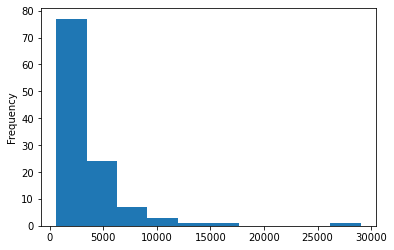

In [23]:
y_train.plot.hist()

<AxesSubplot:ylabel='Frequency'>

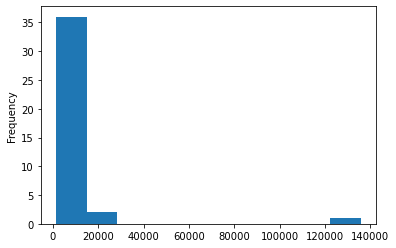

In [24]:
y_test.plot.hist()

# Modelagem

In [25]:
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error